[Data](http://www.thumos.info/download.html)

In [1]:
import torch
import os
import json
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Lambda

class ClassDataset(Dataset):
    """Forms a dataset from a folder uri with every example associated with a single class"""
    def __init__(self, vid_dir, label, transform=None, target_transform=None):
        self.vid_labels = os.listdir(vid_dir)
        self.vid_dir = vid_dir
        self.label = label
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.vid_labels)

    def __getitem__(self, idx):
        vid_data = os.path.join(self.vid_dir, self.vid_labels[idx])
        if self.transform:
            vid_data = self.transform(vid_data)
        if self.target_transform:
            label = self.target_transform(self.label)
        return vid_data, label

ANNOTATION_LIST = ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 
                   'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress', 
                   'Biking', 'Billiards', 'BlowDryHair', 'BlowingCandles', 'BodyWeightSquats', 
                   'Bowling', 'BoxingPunchingBag', 'BoxingSpeedBag', 'BreastStroke', 'BrushingTeeth', 
                   'CleanAndJerk', 'CliffDiving', 'CricketBowling', 'CricketShot', 'CuttingInKitchen', 
                   'Diving', 'Drumming', 'Fencing', 'FieldHockeyPenalty', 'FloorGymnastics', 
                   'FrisbeeCatch', 'FrontCrawl', 'GolfSwing', 'Haircut', 'Hammering', 'HammerThrow', 
                   'HandstandPushups', 'HandstandWalking', 'HeadMassage', 'HighJump', 'HorseRace', 
                   'HorseRiding', 'HulaHoop', 'IceDancing', 'JavelinThrow', 'JugglingBalls', 
                   'JumpingJack', 'JumpRope', 'Kayaking', 'Knitting', 'LongJump', 'Lunges', 
                   'MilitaryParade', 'Mixing', 'MoppingFloor', 'Nunchucks', 'ParallelBars', 
                   'PizzaTossing', 'PlayingCello', 'PlayingDaf', 'PlayingDhol', 'PlayingFlute', 
                   'PlayingGuitar', 'PlayingPiano', 'PlayingSitar', 'PlayingTabla', 'PlayingViolin', 
                   'PoleVault', 'PommelHorse', 'PullUps', 'Punch', 'PushUps', 'Rafting', 'RockClimbingIndoor', 
                   'RopeClimbing', 'Rowing', 'SalsaSpin', 'ShavingBeard', 'Shotput', 'SkateBoarding', 
                   'Skiing', 'Skijet', 'SkyDiving', 'SoccerJuggling', 'SoccerPenalty', 'StillRings', 
                   'SumoWrestling', 'Surfing', 'Swing', 'TableTennisShot', 'TaiChi', 'TennisSwing', 
                   'ThrowDiscus', 'TrampolineJumping', 'Typing', 'UnevenBars', 'VolleyballSpiking', 
                   'WalkingWithDog', 'WallPushups', 'WritingOnBoard', 'YoYo']

def annotation_to_num(annotation):
    """Converts a string annotation to a number"""
    return ANNOTATION_LIST.index(annotation)

def num_to_annotation(num):
    """Converts a number to a string annotation"""
    return ANNOTATION_LIST[num]

VID_DIR = "C:\\Users\\menez\\Documents\\VSCode\\MLPlayground\\VideoClassification\\data\\UCF101_videos\\Slow"

In [2]:
with open("data/kinetics_classnames.json", "r") as f:
    kinetics_classnames = json.load(f)

# Create an id to label name mapping
kinetics_id_to_classname = {}
for k, v in kinetics_classnames.items():
    kinetics_id_to_classname[v] = str(k).replace('"', "")

In [3]:
# Crate class dataset map

slow_class_datasets = {key: ClassDataset(os.path.join(VID_DIR, key), 
                                       key, 
                                       transform=Lambda(lambda y: torch.load(y).to('cuda')),
                                       target_transform=Lambda(lambda y: torch.zeros(101, dtype=torch.float).scatter_(0, torch.tensor(annotation_to_num(y)), value=1))) 
                    for key in ANNOTATION_LIST}

In [4]:
generator = torch.Generator().manual_seed(42)

# Datasets
split_slow_class_datasets = {key: torch.utils.data.random_split(slow_class_datasets[key], [0.8, 0.2], generator=generator) for key in slow_class_datasets}
slow_testing_dataset = torch.utils.data.ConcatDataset(split_slow_class_datasets[key][1] for key in split_slow_class_datasets)

In [5]:
# Dataloaders
batch_size = 2 # 64

# Create data loaders.
split_slow_class_training_dataloaders = {key: [DataLoader(split_slow_class_datasets[key][0], batch_size=batch_size), 
                                               DataLoader(split_slow_class_datasets[key][1], batch_size=batch_size)] 
                                        for key in split_slow_class_datasets}

slow_testing_dataloader = DataLoader(slow_testing_dataset, batch_size=batch_size)

In [6]:
import random
sampling_weights = [len(slow_class_datasets[key]) for key in ANNOTATION_LIST]
print(random.choices(ANNOTATION_LIST, weights=sampling_weights, k=1))

['FieldHockeyPenalty']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


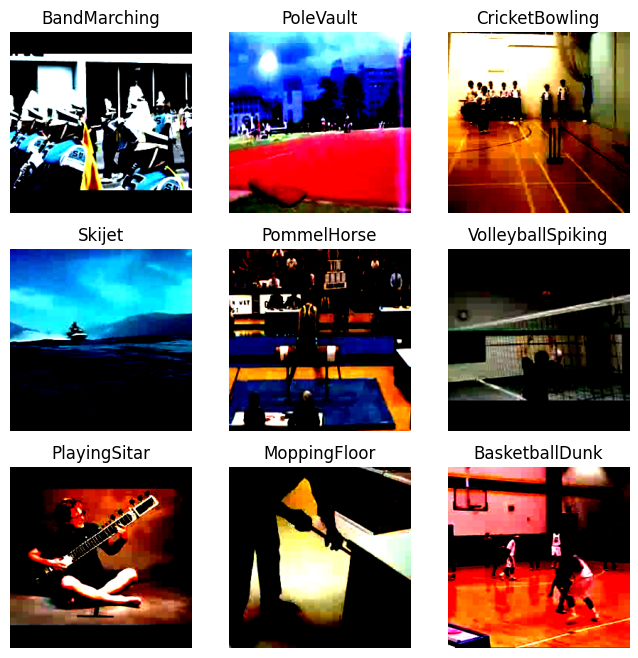

In [7]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# note: clipping notice results from the image tensor being normalized 
# to values outside the expected image format. i.e. nomalized values are
# good for learning but not for viewing

for i in range(1, cols * rows + 1):
    # choose random class (weighted sample to make probability of choosing any example equal)
    label = random.choices(ANNOTATION_LIST, weights=sampling_weights, k=1)[0]
    sample_idx = torch.randint(len(split_slow_class_datasets[label][0]), size=(1,)).item()
    video, _ = split_slow_class_datasets[label][0][sample_idx]
    # print(video.shape)
    # img = video[0]
    # print(video[0, :, 0, :, :].shape)
    # print(video[0, :, 0, :, :])
    img = video[0, :, 0, :, :].permute(1, 2, 0)
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.cpu().squeeze(), cmap="gray")
plt.show()

[3D Resnet Model](https://pytorch.org/hub/facebookresearch_pytorchvideo_resnet/)

In [8]:
import torch
# Choose the `slow_r50` model 
model = torch.hub.load('facebookresearch/pytorchvideo', 'slow_r50', pretrained=True)

# Set to GPU or CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.eval()
model = model.to(device)

Using cache found in C:\Users\menez/.cache\torch\hub\facebookresearch_pytorchvideo_main


Slow Inference

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


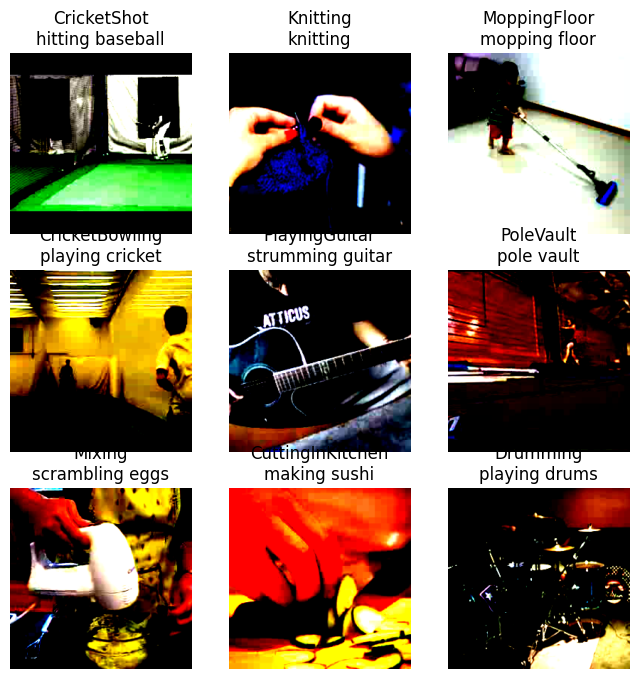

In [9]:
from torchvision.io import read_video

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    # choose random class (weighted sample to make probability of choosing any example equal)
    label = random.choices(ANNOTATION_LIST, weights=sampling_weights, k=1)[0]
    sample_idx = torch.randint(len(split_slow_class_datasets[label][0]), size=(1,)).item()
    video, _ = split_slow_class_datasets[label][0][sample_idx]
    img = video[0, :, 0, :, :].permute(1, 2, 0)
    preds = model(video)

    # Get the predicted classes
    post_act = torch.nn.Softmax(dim=1)
    preds = post_act(preds)
    pred_classes = preds.topk(k=1).indices

    # Map the predicted classes to the label names
    pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes[0]]
    # print("Predicted labels: %s" % ", ".join(pred_class_names))

    label = label + "\n" + pred_class_names[0]

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.cpu().squeeze(), cmap="gray")
plt.show()

Fine Tuning

In [10]:
# Changing the output from 400 to 101
model.blocks[5].proj = torch.nn.Linear(2048, 101, bias=True)

In [11]:
# Set to GPU or CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.train()
model = model.to(device)

In [12]:
device

'cuda'

In [13]:
plst = [
    {'params': model.blocks[5].parameters(), 'lr': 1e-3}
]

Declaring loss function and optimizer

In [15]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Training the model

CSSL Training

In [16]:
import random

def cssl_train(dataloader_map, model, loss_fn, optimizer, buffer_size):
    size = sum([len(dataloader_map[key][0].dataset) for key in dataloader_map])
    model.train()
    batch = 0
    buffer_map = {}
    annotation_map = {}
    # class_order = ANNOTATION_LIST.copy()
    # random.shuffle(class_order)
    # torch.save(class_order, "class_order.ptlst")
    class_order = torch.load("class_order.ptlst")
    for class_num in range(101):
        classification = class_order[class_num]
        for (X, y) in dataloader_map[classification][0]:
            X, y = X.to('cpu'), y.to('cpu')
            # Update annotation_map and buffer_map
            if buffer_map.get(classification, None) == None:
                buffer_map[classification] = []
                annotation_map[classification] = 0
            buffer_map[classification].append((X, y))
            annotation_map[classification] += 1

            # Eviction policy: randomly remove an example from the class with the most examples in the buffer
            if sum(annotation_map.values()) > buffer_size:
                freq_annotation = max(annotation_map, key=annotation_map.get)
                choice = random.randint(0, annotation_map[freq_annotation]-1)
                buffer_map[freq_annotation].pop(choice)
                annotation_map[freq_annotation] -= 1

            # Convert buffer_map to buffer
            buffer = []
            for key in buffer_map:
                buffer.extend(buffer_map[key])

            # Randomly select from buffer
            (X, y) = random.choice(buffer)
            X, y = X.to(device), y.to(device)
            
            # Compute prediction error
            pred = model(X[:, 0, :, :, :, :])
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            batch += 1

Testing the model

In [17]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X[:, 0, :, :, :, :])
            test_loss += loss_fn(pred, y).item()
            # print(pred.argmax(1))
            # print(y.argmax(1))
            # print(pred.argmax(1) == y.argmax(1))
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [18]:
torch.cuda.empty_cache()

Running the model and testing after each epoch

In [19]:
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    cssl_train(split_slow_class_training_dataloaders, model, loss_fn, optimizer, 18) # 18 examples ~> 150 MB
    test(slow_testing_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4.318637  [    2/10690]
loss: 2.412121  [  202/10690]
loss: 4.197711  [  402/10690]
loss: 3.069386  [  602/10690]
loss: 0.779148  [  802/10690]
loss: 1.294865  [ 1002/10690]
loss: 3.452211  [  601/10690]
loss: 1.788064  [ 1402/10690]
loss: 0.703298  [ 1602/10690]
loss: 2.290159  [ 1802/10690]
loss: 2.004080  [ 2002/10690]
loss: 1.762702  [ 2202/10690]
loss: 1.245992  [ 2402/10690]
loss: 2.840737  [ 2602/10690]
loss: 5.779838  [ 2802/10690]
loss: 1.338998  [ 3002/10690]
loss: 2.199071  [ 3202/10690]
loss: 4.949439  [ 3402/10690]
loss: 1.232996  [ 3602/10690]
loss: 3.165240  [ 3802/10690]
loss: 2.349352  [ 4002/10690]
loss: 1.331778  [ 2101/10690]
loss: 4.334710  [ 4402/10690]
loss: 4.623055  [ 2301/10690]
loss: 3.403234  [ 4802/10690]
loss: 4.411207  [ 5002/10690]
loss: 2.769984  [ 5202/10690]
loss: 2.285229  [ 5402/10690]
loss: 1.273723  [ 2801/10690]
loss: 1.059434  [ 2901/10690]
loss: 2.028160  [ 6002/10690]
loss: 1.951282  [ 6202/10690]


Saving the model

In [20]:
file_destination = "unfrozen_cssl.pth"
torch.save(model.state_dict(), file_destination)
print("Saved PyTorch Model State to " + str(file_destination))

Saved PyTorch Model State to unfrozen_cssl.pth


Redoing Slow Inference (Fine Tuned)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


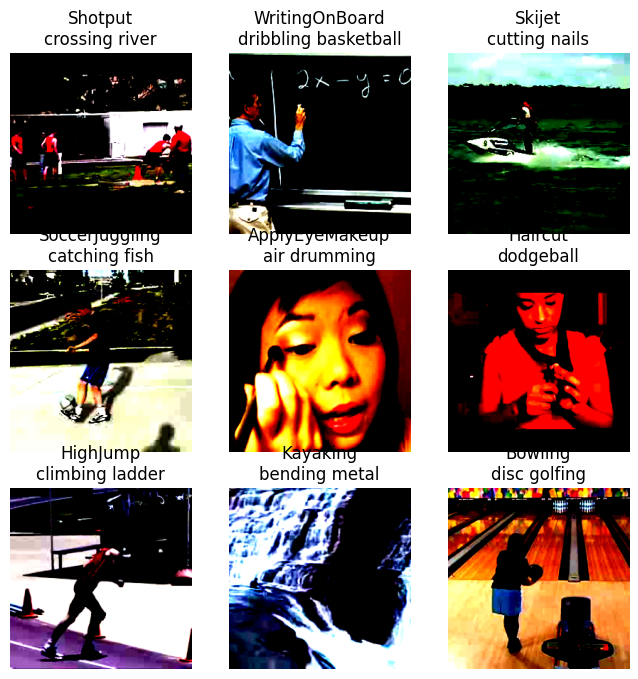

In [24]:
from torchvision.io import read_video

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    # choose random class (weighted sample to make probability of choosing any example equal)
    label = random.choices(ANNOTATION_LIST, weights=sampling_weights, k=1)[0]
    sample_idx = torch.randint(len(split_slow_class_datasets[label][1]), size=(1,)).item()
    video, _ = split_slow_class_datasets[label][1][sample_idx]
    img = video[0, :, 0, :, :].permute(1, 2, 0)
    preds = model(video)

    # Get the predicted classes
    post_act = torch.nn.Softmax(dim=1)
    preds = post_act(preds)
    pred_classes = preds.topk(k=1).indices

    # Map the predicted classes to the label names
    pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes[0]]
    # print("Predicted labels: %s" % ", ".join(pred_class_names))

    label = label + "\n" + pred_class_names[0]

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.cpu().squeeze(), cmap="gray")
plt.show()